### Histopathologic Cancer Detection

Task: Creating an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans.

1. Dataset contains 96x96 small pathology images.
2. Labels about the center 32x32px region of a patch.
3. Tumor tissue in the outer region of the patch does not influence the label.

## Analysis of the dataset

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.patches as patches
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import shuffle
from tqdm import tqdm_notebook

import os
import cv2

# Seaborn for plotting and styling
import seaborn as sns
sns.set()


train_path = 'train/'
test_path = 'test/'

#### Loading data

In [2]:
df = pd.read_csv('train_labels.csv')

Checking distribution of postive and negative labels in the data. It seems like it's about 60/40

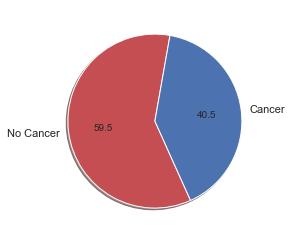

<Figure size 1152x1152 with 0 Axes>

In [9]:
labels_count = df.label.value_counts()

%matplotlib inline
plt.pie(labels_count, labels=['No Cancer', 'Cancer'], startangle=80, 
        autopct='%1.1f', colors=['r','b'], shadow=True)
plt.figure(figsize=(16,16))
plt.show()

0    130908
1     89117
Name: label, dtype: int64

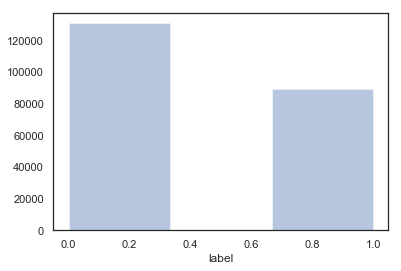

In [3]:
with sns.axes_style('white'):
    sns.distplot(df['label'], kde=False, bins=3);
df['label'].value_counts()

Only the center 32x32 region of the images are important in this problem. 

In [4]:
def readImage(path, train=True):
    path = train_path + path if train else test_path + path
    bgr_img = cv2.imread(path)
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img

In [7]:
def plot_samples(n=10, showBox=True):
    with sns.axes_style('white'):
        fig, ax = plt.subplots(2, 5, figsize = (15, 7))
        ax = ax.flatten()
        imgs = []

        for i, (_,sample) in enumerate(df.sample(n=n).iterrows()):
            imgs.append(readImage(sample.id + '.tif'))

            # rectangle patch for the center 32x32
            if showBox:
                color = 'b' if sample['label'] else 'r'
                rect = patches.Rectangle((32,32),32,32,linewidth=3, ls='--', edgecolor=color,facecolor='none')
                ax[i].add_patch(rect)
            ax[i].imshow(imgs[-1])
            ax[i].set(xlabel='cancer' if sample['label'] else 'no cancer')

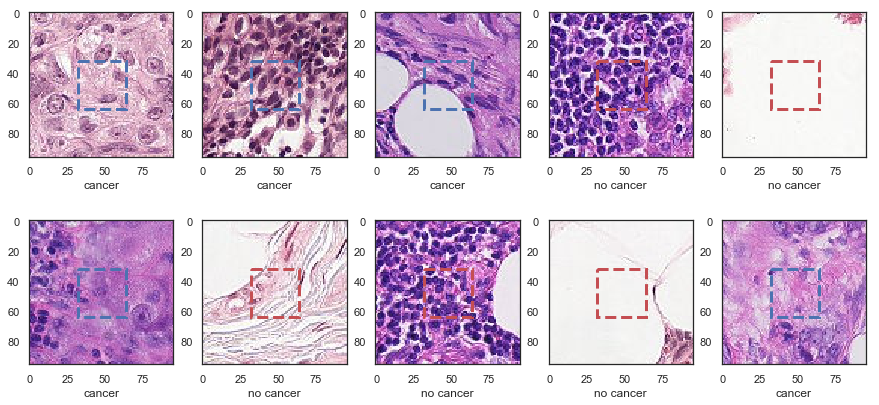

In [10]:
plot_samples()

### Proprocessing and Augmentations

Since the problem labels only look at the center 32x32 region, we need to crop the images. 

Now, we want to add augmentations. I will be adding the following augmentations:

- random crop (this depends of whether the image is bigger)
- random horizontal or vertical flip
- random rotation
- Gaussian blur

In [122]:
import random
ORIGINAL_SIZE = 96      

# AUGMENTATIONs
CROP_SIZE = 90          
RANDOM_ROTATION = 15    
RANDOM_SHIFT = 6        
RANDOM_BRIGHTNESS = 15  
RANDOM_CONTRAST = 15    
RANDOM_90_DEG_TURN = 1  

In [123]:
def readCroppedImage(path, augmentations = True):
    # augmentations parameter is included for counting statistics from images, where we don't want augmentations
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    
    if(not augmentations):
        return rgb_img / 255
    
    #random rotation
    rotation = random.randint(-RANDOM_ROTATION,RANDOM_ROTATION)
    if(RANDOM_90_DEG_TURN == 1):
        rotation += random.randint(-1,1) * 90
    M = cv2.getRotationMatrix2D((48,48),rotation,1)   # the center point is the rotation anchor
    rgb_img = cv2.warpAffine(rgb_img,M,(96,96))
    
    #random x,y-shift
    x = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT)
    y = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT)
    
    # crop to center and normalize to 0-1 range
    start_crop = (ORIGINAL_SIZE - CROP_SIZE) // 2
    end_crop = start_crop + CROP_SIZE
    rgb_img = rgb_img[(start_crop + x):(end_crop + x), (start_crop + y):(end_crop + y)] / 255
    
    # Random flip
    flip_hor = bool(random.getrandbits(1))
    flip_ver = bool(random.getrandbits(1))
    if(flip_hor):
        rgb_img = rgb_img[:, ::-1]
    if(flip_ver):
        rgb_img = rgb_img[::-1, :]
        
    # Random brightness
    br = random.randint(-RANDOM_BRIGHTNESS, RANDOM_BRIGHTNESS) / 100.
    rgb_img = rgb_img + br
    
    # Random contrast
    cr = 1.0 + random.randint(-RANDOM_CONTRAST, RANDOM_CONTRAST) / 100.
    rgb_img = rgb_img * cr
    
    # clip values to 0-1 range
    rgb_img = np.clip(rgb_img, 0, 1.0)
    
    return rgb_img

In [124]:
def plot_cropped_samples():
    fig, ax = plt.subplots(2,5, figsize=(20,8))
    fig.suptitle('Cropped histopathologic slides',fontsize=20)

    # Negatives
    for i, idx in enumerate(df[df['label'] == 0]['id'][:5]):
        path = os.path.join(train_path, idx)
        ax[0,i].imshow(readCroppedImage(path + '.tif'))
    ax[0,0].set_ylabel('Negative samples', size='large')

    # Positives
    for i, idx in enumerate(df[df['label'] == 1]['id'][:5]):
        path = os.path.join(train_path, idx)
        ax[1,i].imshow(readCroppedImage(path + '.tif'))
    ax[1,0].set_ylabel('Tumor tissue samples', size='large')

In [125]:
def plot_random_augmentations():
    fig, ax = plt.subplots(1,5, figsize=(20,4))
    fig.suptitle('Random augmentations',fontsize=20)
    # Negatives
    for i, idx in enumerate(df[df['label'] == 0]['id'][:1]):
        for j in range(5):
            path = os.path.join(train_path, idx)
            ax[j].imshow(readCroppedImage(path + '.tif'))

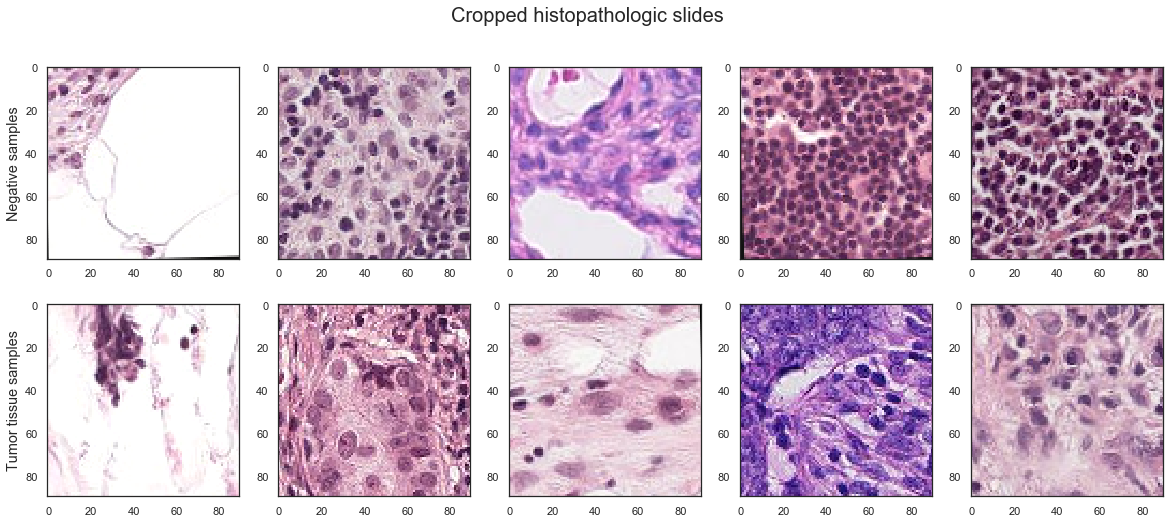

In [126]:
with sns.axes_style('white'):
    plot_cropped_samples()

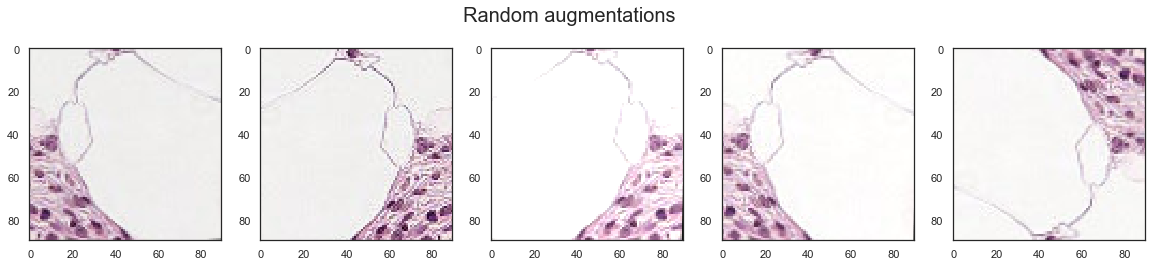

In [127]:
with sns.axes_style('white'):
    plot_random_augmentations()

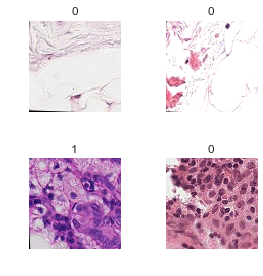

In [133]:
imgDataBunch.show_batch(rows=2, figsize=(4,4))